<a href="https://www.cognitiveclass.ai"><img src = "https://cognitiveclass.ai/wp-content/themes/bdu3.0/static/images/cc-logo.png" align = left></a>

<br>
<br>

--------------------
# SETI CNN using TF and Binary DS

In [6]:
import requests
import json
#import ibmseti
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import pickle
import time
!sudo pip install sklearn
import os
from sklearn.metrics import confusion_matrix
from sklearn import metrics

### Set your team folder

In [7]:
### SET YOUR TEAM NAME HERE! Use this folder to save intermediate results
mydatafolder = "/tmp/SETI1_data"
if os.path.exists(mydatafolder) is False:
    os.makedirs(mydatafolder)
print mydatafolder

train_dir = '/tmp/SETI1_train'
if os.path.exists(train_dir) is False:
    os.makedirs(train_dir)
print train_dir

/tmp/SETI1_data
/tmp/SETI1_train


### Import dataset reader
The following cell will load a python code to read the SETI dataset.

In [8]:
!wget --output-document SETI.zip  https://ibm.box.com/shared/static/jhqdhcblhua5dx2t7ixwm88okitjrl6l.zip
!unzip -o SETI.zip
import SETI

--2017-08-25 04:46:44--  https://ibm.box.com/shared/static/jhqdhcblhua5dx2t7ixwm88okitjrl6l.zip
Resolving ibm.box.com (ibm.box.com)... 107.152.26.197, 107.152.27.197
Connecting to ibm.box.com (ibm.box.com)|107.152.26.197|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://ibm.ent.box.com/shared/static/jhqdhcblhua5dx2t7ixwm88okitjrl6l.zip [following]
--2017-08-25 04:46:45--  https://ibm.ent.box.com/shared/static/jhqdhcblhua5dx2t7ixwm88okitjrl6l.zip
Resolving ibm.ent.box.com (ibm.ent.box.com)... 107.152.26.211, 107.152.27.211
Connecting to ibm.ent.box.com (ibm.ent.box.com)|107.152.26.211|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://public.boxcloud.com/d/1/BcCAqLM33SYa2XF6QwM0RRgGoxSMMooIYYrQ_MsUxocdBVxnDtUcWj2P68lOmHY22vkxrcxac13AMovUb0_CYOpR8A_90N84MEkZVaasz9WuNt5SrlKemHydQyCnkALO7MjWAfCPV8gqOX70YXdautlkGiUfz9ocviezak2hwYjLth2Va6l6HxzFFp0fhpvg8VB0ybKprQmVzwy-f9yS7repAgq-sNdgXl0nXPcCN4JvC43-5XEz7xoU2

### Download data

In [9]:
from six.moves import urllib
import sys
import tarfile
def maybe_download_and_extract():
    data_dir = "/tmp/SETI1_data"
    DATA_URL =  'https://ibm.box.com/shared/static/qz33lcio9ip2j8qi2atxqs62gn3bnu2s.gz'
    dest_directory = data_dir
    if not os.path.exists(dest_directory):
        os.makedirs(dest_directory)
    filename = DATA_URL.split('/')[-1]
    filepath = os.path.join(dest_directory, filename)
    if not os.path.exists(filepath):
        def _progress(count, block_size, total_size):
            sys.stdout.write('\r>> Downloading %s %.1f%%' % (filename, float(count * block_size) / float(total_size) * 100.0))
        sys.stdout.flush()
        filepath, _ = urllib.request.urlretrieve(DATA_URL, filepath, _progress)
    print()
    statinfo = os.stat(filepath)
    print('Successfully downloaded', filename, statinfo.st_size, 'bytes.')
    extracted_dir_path = os.path.join(dest_directory, 'SETI_ds_64x128')
    if not os.path.exists(extracted_dir_path):
        tarfile.open(filepath, 'r:gz').extractall(dest_directory)

In [10]:
maybe_download_and_extract()

()
('Successfully downloaded', 'qz33lcio9ip2j8qi2atxqs62gn3bnu2s.gz', 2432541, 'bytes.')


### Load data SETI

In [11]:
ds_directory = mydatafolder + '/SETI_ds_64x128/'
dataset = SETI.read_data_sets(ds_directory, one_hot=True, validation_size=0)
dataset.train.images.shape

Extracting /tmp/SETI1_data/SETI_ds_64x128/train-images-idx3-ubyte.gz
Extracting /tmp/SETI1_data/SETI_ds_64x128/train-labels-idx1-ubyte.gz
Extracting /tmp/SETI1_data/SETI_ds_64x128/test-images-idx3-ubyte.gz
Extracting /tmp/SETI1_data/SETI_ds_64x128/test-labels-idx1-ubyte.gz


(694, 8192)

## Network Parameters

In [12]:
# Parameters
decay_rate=0.96  #decay every 1000 steps with a base of 0.96:
decay_steps=1000
learning_rate = 0.005
training_epochs = 3000
batch_size = 50
display_step = 100
MOVING_AVERAGE_DECAY = 0.9999     # The decay to use for the moving average.

#check point directory
chk_directory = train_dir+'/save/'
checkpoint_path = chk_directory + 'model.ckpt'


n_classes = 4 # number of possible classifications for the problem
dropout = 0.50 # Dropout, probability to keep units

height = 64 # height of the image in pixels 
width = 128 # width of the image in pixels 
n_input = width * height # number of pixels in one image 


### Inputs

In [13]:
x  = tf.placeholder(tf.float32, shape=[None, n_input])
y_ = tf.placeholder(tf.float32, shape=[None, n_classes])

In [14]:
x_image = tf.reshape(x, [-1,height,width,1]) 
x_image

<tf.Tensor 'Reshape:0' shape=(?, 64, 128, 1) dtype=float32>

#### Convolutional Layer 1

In [15]:
W_conv1 = tf.Variable(tf.truncated_normal([5, 5, 1, 32], stddev=0.1))
b_conv1 = tf.Variable(tf.constant(0.1, shape=[32])) # need 32 biases for 32 outputs
convolve1 = tf.nn.conv2d(x_image, W_conv1, strides=[1, 1, 1, 1], padding='SAME') + b_conv1
h_conv1 = tf.nn.relu(convolve1)
conv1 = tf.nn.max_pool(h_conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME') #max_pool_2x2
conv1

<tf.Tensor 'MaxPool:0' shape=(?, 32, 64, 32) dtype=float32>

#### Convolutional Layer 2

In [16]:
W_conv2 = tf.Variable(tf.truncated_normal([5, 5, 32, 64], stddev=0.1))
b_conv2 = tf.Variable(tf.constant(0.1, shape=[64])) #need 64 biases for 64 outputs
convolve2= tf.nn.conv2d(conv1, W_conv2, strides=[1, 1, 1, 1], padding='SAME')+ b_conv2
h_conv2 = tf.nn.relu(convolve2)
conv2 = tf.nn.max_pool(h_conv2, ksize=[1, 2, 2, 1], strides=[1, 4, 4, 1], padding='SAME') #max_pool_2x2
conv2

<tf.Tensor 'MaxPool_1:0' shape=(?, 8, 16, 64) dtype=float32>

#### Convolutional Layer 3

#### Convolutional Layer 4

#### Fully Connected Layer 1

In [17]:
input_layer = conv2
dim = input_layer.get_shape().as_list()
dim

[None, 8, 16, 64]

In [18]:
dims= dim[1]*dim[2]*dim[3]
nodes1 = 1024
prv_layer_matrix = tf.reshape(input_layer, [-1, dims])
W_fc1 = tf.Variable(tf.truncated_normal([dims, nodes1], stddev=0.1))
b_fc1 = tf.Variable(tf.constant(0.1, shape=[nodes1])) # need 1024 biases for 1024 outputs
h_fcl1  = tf.matmul(prv_layer_matrix, W_fc1) + b_fc1
fc_layer1 = tf.nn.relu(h_fcl1) # ???
fc_layer1


<tf.Tensor 'Relu_2:0' shape=(?, 1024) dtype=float32>

#### Droupout 1

In [19]:
keep_prob = tf.placeholder(tf.float32)
layer_drop1 = tf.nn.dropout(fc_layer1, keep_prob)

#### Fully Connected Layer 2

#### Droupout 2

#### Readout Layer

In [20]:
W_fc = tf.Variable(tf.truncated_normal([nodes1, n_classes], stddev=0.1)) #1024 neurons
b_fc = tf.Variable(tf.constant(0.1, shape=[n_classes])) # 10 possibilities for classes [0,1,2,3]
fc = tf.matmul(layer_drop1, W_fc) + b_fc
y_CNN= tf.nn.softmax(fc)

#### Loss function

In [21]:
#loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_CNN, labels=y_))

In [22]:
# Calculate the total loss on a single tower running the SETI model.
def tower_loss(scope, images, labels):
    cross_entropy_mean = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_CNN, labels=y_))
    tf.add_to_collection('losses', cross_entropy_mean)
    #_ = tf.add_n(tf.get_collection('losses'), name='total_loss')

    # Assemble all of the losses for the current tower only.
    # 'losses' is the key for collection
    # scope is for e.g. 'tower_0'
    losses = tf.get_collection('losses', scope)

    # Calculate the total loss for the current tower.
    total_loss = tf.add_n(losses, name='total_loss')

    return total_loss

#### Gradients
  """Calculate the average gradient for each shared variable across all towers.

  Note that this function provides a synchronization point across all towers.

  Args:
    tower_grads: List of lists of (gradient, variable) tuples. The outer list
      is over individual gradients. The inner list is over the gradient
      calculation for each tower.
  Returns:
     List of pairs of (gradient, variable) where the gradient has been averaged
     across all towers.
  """

In [23]:
def average_gradients(tower_grads):
    average_grads = []
    for grad_and_vars in zip(*tower_grads):
    # Note that each grad_and_vars looks like the following:
    #   ((grad0_gpu0, var0_gpu0), ... , (grad0_gpuN, var0_gpuN))
        grads = []
        for g, _ in grad_and_vars:
            # Add 0 dimension to the gradients to represent the tower.
            expanded_g = tf.expand_dims(g, 0)

            # Append on a 'tower' dimension which we will average over below.
            grads.append(expanded_g)

        # Average over the 'tower' dimension.
        grad = tf.concat(axis=0, values=grads)
        grad = tf.reduce_mean(grad, 0)

        # Keep in mind that the Variables are redundant because they are shared
        # across towers. So .. we will just return the first tower's pointer to
        # the Variable.
        v = grad_and_vars[0][1]
        grad_and_var = (grad, v)
        average_grads.append(grad_and_var)
    return average_grads

#### Training


In [24]:
# Create a variable to track the global step.
global_step = tf.Variable(0, trainable=False)

# create learning_decay
# Decay the learning rate exponentially based on the number of steps.
lr = tf.train.exponential_decay( learning_rate,
                                 global_step,
                                 decay_steps,
                                 decay_rate, staircase=True )


In [25]:
# Use the optimizer to apply the gradients that minimize the loss
# (and also increment the global step counter) as a single training step.
optimizer = tf.train.GradientDescentOptimizer(lr)

# Calculate the gradients for the batch of data on this SETI tower.
#grads = opt.compute_gradients(loss)

#train_op = optimizer.minimize(loss, global_step=global_step)
#train_op = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cross_entropy)

In [27]:
tower_grads = []
with tf.variable_scope(tf.get_variable_scope()):
    for i in xrange(4):
        with tf.device('/gpu:%d' % i):
            with tf.name_scope('%s_%d' % ('tower_', i)) as scope:
            # Dequeues one batch for the GPU
            #image_batch, label_batch = batch_queue.dequeue()
                x_batch, y_batch = dataset.train.next_batch(batch_size,shuffle=True)
                # Calculate the loss for one tower of the SETI model. This function
                # constructs the entire SETI model but shares the variables across
                # all towers.
                loss = tower_loss(scope, x_batch, y_batch)
                # Reuse variables for the next tower.
                tf.get_variable_scope().reuse_variables()
                grads = optimizer.compute_gradients(loss)
                tower_grads.append(grads)
grads = average_gradients(tower_grads)
# Apply the gradients to adjust the shared variables.
apply_gradient_op = optimizer.apply_gradients(grads, global_step=global_step)

# Track the moving averages of all trainable variables.
variable_averages = tf.train.ExponentialMovingAverage(MOVING_AVERAGE_DECAY, global_step)
variables_averages_op = variable_averages.apply(tf.trainable_variables())

# Group all updates to into a single train op.
# we call train_op in learning process
# tf.group Creates an op that groups multiple operations.
# When this op finishes, all ops in input have finished. This op has no output.
train_op = tf.group(apply_gradient_op, variables_averages_op)

#### Evaluation

In [28]:
correct_prediction = tf.equal(tf.argmax(y_CNN,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

### Create checkpoint directory

In [29]:
directory = os.path.dirname(chk_directory)
try:
    os.stat(directory)
    ckpt = tf.train.get_checkpoint_state(chk_directory)
    print ckpt
except:
    os.mkdir(directory) 

model_checkpoint_path: "/tmp/SETI1_train/save/model.ckpt-36000"
all_model_checkpoint_paths: "/tmp/SETI1_train/save/model.ckpt-36000"



## Training

In [30]:
# Initializing the variables
init = tf.global_variables_initializer()

In [31]:
loss_values = []

X_test = dataset.test.images
y_test = dataset.test.labels

sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True))
sess.run(init)
saver = tf.train.Saver(tf.global_variables())

# load previously trained model if appilcable
ckpt = tf.train.get_checkpoint_state(chk_directory)
if ckpt:
    print "loading model: ",ckpt.model_checkpoint_path
    #saver.restore(sess, ckpt.model_checkpoint_path)

    


loading model:  /tmp/SETI1_train/save/model.ckpt-36000


In [32]:
#step = 0
num_examples = dataset.train.num_examples
# Training cycle
for epoch in range(training_epochs):
    avg_loss = 0.
    avg_accuracy = 0.
    #dataset.shuffle_data()
    total_batch = int(num_examples / batch_size)

    # Loop over all batches in one epoch
    start = time.time()
    for step in range(total_batch):
        x_batch, y_batch = dataset.train.next_batch(batch_size,shuffle=True)
        sess.run(train_op, feed_dict={x: x_batch, y_: y_batch, keep_prob: dropout})
        loss_value = sess.run(loss, feed_dict={x: x_batch,y_: y_batch,keep_prob: 1.})
        assert not np.isnan(loss_value), 'Model diverged with loss = NaN'
        acc = sess.run(accuracy, feed_dict={x: x_batch,y_: y_batch,keep_prob: 1.})
        #loss, acc = sess.run([cross_entropy, accuracy], feed_dict={x: x_batch,y_: y_batch,keep_prob: 1.})
        avg_loss += loss_value / total_batch
        avg_accuracy += acc / total_batch
        
    # Display model every 1 epochs
    if epoch >= 0 and epoch % 10 == 0:
        end = time.time()
        plr = sess.run(lr)
        g_step = sess.run(global_step)
        loss_values.append(avg_loss)
        #print(sess.run(tf.train.global_step()))
        print "Epoch:", '%04d' % (epoch+1) , ", g_step:", '%04d' % (g_step) , ", E_time=" , "{:.5f}".format(end - start) , ", lr=", "{:.9f}".format(plr), ", cost=", "{:.9f}".format(avg_loss) ,", Acc=", "{:.9f}".format(avg_accuracy)
print("Optimization Finished!")
print ("model saved to {}".format(checkpoint_path))
saver.save(sess, checkpoint_path, global_step = (epoch+1)*step)

Epoch: 0001 , g_step: 0013 , E_time= 2.68189 , lr= 0.005000000 , cost= 1.383855471 , Acc= 0.303076917
Epoch: 0011 , g_step: 0143 , E_time= 0.72803 , lr= 0.005000000 , cost= 1.259026335 , Acc= 0.476923060
Epoch: 0021 , g_step: 0273 , E_time= 0.69739 , lr= 0.005000000 , cost= 1.233594913 , Acc= 0.507692289
Epoch: 0031 , g_step: 0403 , E_time= 0.71330 , lr= 0.005000000 , cost= 1.194181479 , Acc= 0.503076913
Epoch: 0041 , g_step: 0533 , E_time= 0.71216 , lr= 0.005000000 , cost= 1.201645778 , Acc= 0.501538446
Epoch: 0051 , g_step: 0663 , E_time= 0.69668 , lr= 0.005000000 , cost= 1.185030213 , Acc= 0.524615370
Epoch: 0061 , g_step: 0793 , E_time= 0.70768 , lr= 0.005000000 , cost= 1.171740825 , Acc= 0.532307675
Epoch: 0071 , g_step: 0923 , E_time= 0.71134 , lr= 0.005000000 , cost= 1.171006377 , Acc= 0.506153831
Epoch: 0081 , g_step: 1053 , E_time= 0.69484 , lr= 0.004800000 , cost= 1.168096286 , Acc= 0.559999986
Epoch: 0091 , g_step: 1183 , E_time= 0.70033 , lr= 0.004800000 , cost= 1.164714107

KeyboardInterrupt: 

In [33]:
# Calculate accuracy for test images
#print("Testing Accuracy:", sess.run(accuracy, feed_dict={x: X_test[0:30], y_: y_test[0:30], keep_prob: 1.}))

# Find the labels of test set
y_pred_lb = sess.run(tf.argmax(y_CNN,1), feed_dict={x: X_test[0:100], y_: y_test[0:100], keep_prob: 1.})
y_pred = sess.run(y_CNN, feed_dict={x: X_test[0:100], y_: y_test[0:100], keep_prob: 1.})

# lets save kernels
kernels_l1 = sess.run(tf.reshape(tf.transpose(W_conv1, perm=[2, 3, 0, 1]),[32,-1]))
kernels_l2 = sess.run(tf.reshape(tf.transpose(W_conv2, perm=[2, 3, 0, 1]),[32*64,-1]))

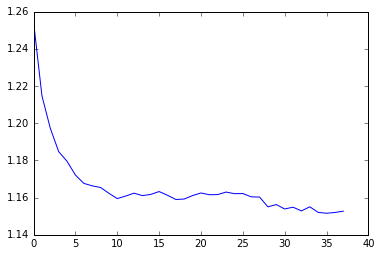

In [34]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.plot([np.mean(loss_values[i:i+5]) for i in range(len(loss_values))])
plt.show()


## Evaluation

Accuracy is depend on the number of epoch that you set in partametrs part.

In [35]:
y_ = np.argmax(y_test[0:100],1) # ground truth
print metrics.classification_report(y_true= y_, y_pred= y_pred_lb)
print metrics.confusion_matrix(y_true= y_, y_pred= y_pred_lb)
print("Classification accuracy: %0.6f" % metrics.accuracy_score(y_true= y_, y_pred= y_pred_lb) )
print("Log Loss: %0.6f" % metrics.log_loss(y_true= y_, y_pred= y_pred, labels=range(4)) )

             precision    recall  f1-score   support

          0       0.37      0.96      0.53        25
          1       1.00      0.04      0.07        28
          2       0.20      0.09      0.12        23
          3       1.00      1.00      1.00        24

avg / total       0.66      0.51      0.42       100

[[24  0  1  0]
 [20  1  7  0]
 [21  0  2  0]
 [ 0  0  0 24]]
Classification accuracy: 0.510000
Log Loss: 0.910155


# Generate CSV file for Scoreboard

Here's an example of what the CSV file should look like for submission to the scoreboard. Although, in this case, we only have 4 classes instead of 7.

#### NOTE: This uses the test set created in Step_5c, which only contain the BASIC4 test data set. The code challenge and hackathon will be based on the Primary Data Set which contains 7 signal classes, and different test set.

In [25]:
my_output_results = mydatafolder + '/' + 'DL_scores.csv'
with open(my_output_results, 'w') as csvfile:
    np.savetxt(my_output_results, y_pred, delimiter=",")

In [26]:
print os.popen("ls -lrt "+ mydatafolder).read() # to verify

total 2392
drwxr-x--- 2  501 root    4096 May 23 02:11 SETI_ds_64x128
-rw-r--r-- 1 root root 2432541 Aug 25 00:49 qz33lcio9ip2j8qi2atxqs62gn3bnu2s.gz
-rw-r--r-- 1 root root   10000 Aug 25 01:12 DL_scores.csv



### Viz

In [27]:
!wget --output-document utils1.py http://deeplearning.net/tutorial/code/utils.py
import utils1
from utils1 import tile_raster_images

--2017-08-25 01:12:56--  http://deeplearning.net/tutorial/code/utils.py
Resolving deeplearning.net (deeplearning.net)... 132.204.26.28
Connecting to deeplearning.net (deeplearning.net)|132.204.26.28|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5097 (5.0K) [text/plain]
Saving to: ‘utils1.py’

utils1.py           100%[===================>]   4.98K  --.-KB/s    in 0s      

2017-08-25 01:12:56 (789 MB/s) - ‘utils1.py’ saved [5097/5097]



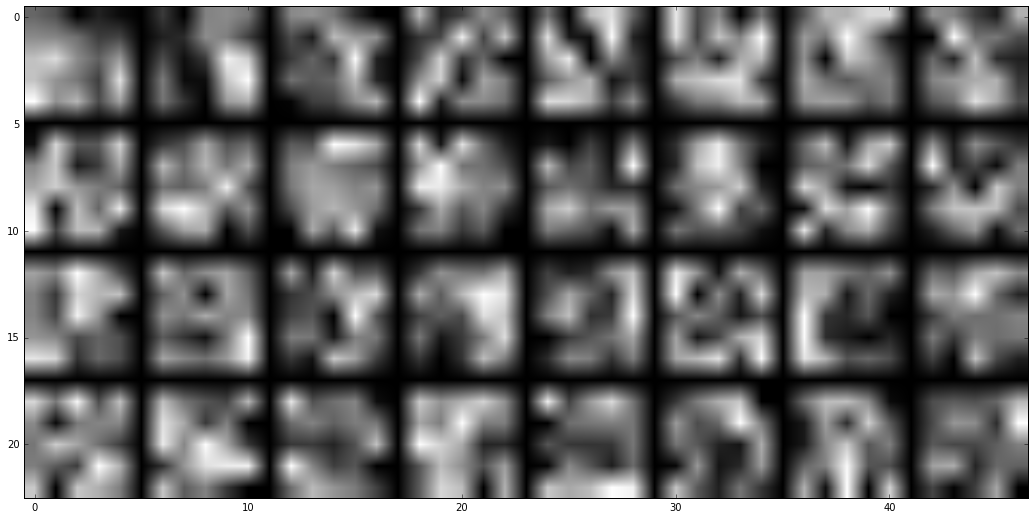

In [28]:
#from utils import tile_raster_images
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline
image = Image.fromarray(tile_raster_images(kernels_l1, img_shape=(5, 5) ,tile_shape=(4, 8), tile_spacing=(1, 1)))
### Plot image
plt.rcParams['figure.figsize'] = (18.0, 18.0)
imgplot = plt.imshow(image)
imgplot.set_cmap('gray')  

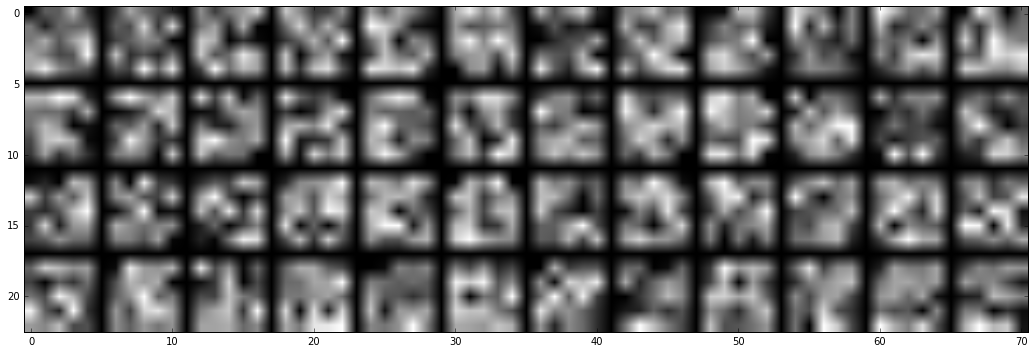

In [29]:
image = Image.fromarray(tile_raster_images(kernels_l2, img_shape=(5, 5) ,tile_shape=(4, 12), tile_spacing=(1, 1)))
### Plot image
plt.rcParams['figure.figsize'] = (18.0, 18.0)
imgplot = plt.imshow(image)
imgplot.set_cmap('gray')  

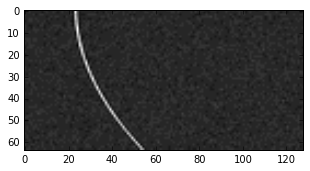

In [30]:
import numpy as np
plt.rcParams['figure.figsize'] = (5.0, 5.0)
sampleimage1 = X_test[3]
plt.imshow(np.reshape(sampleimage1,[64,128]), cmap="gray")

Instructions for updating:
Please use tf.global_variables instead.
loading model:  /tmp/SETI1_train/save/model.ckpt-36000


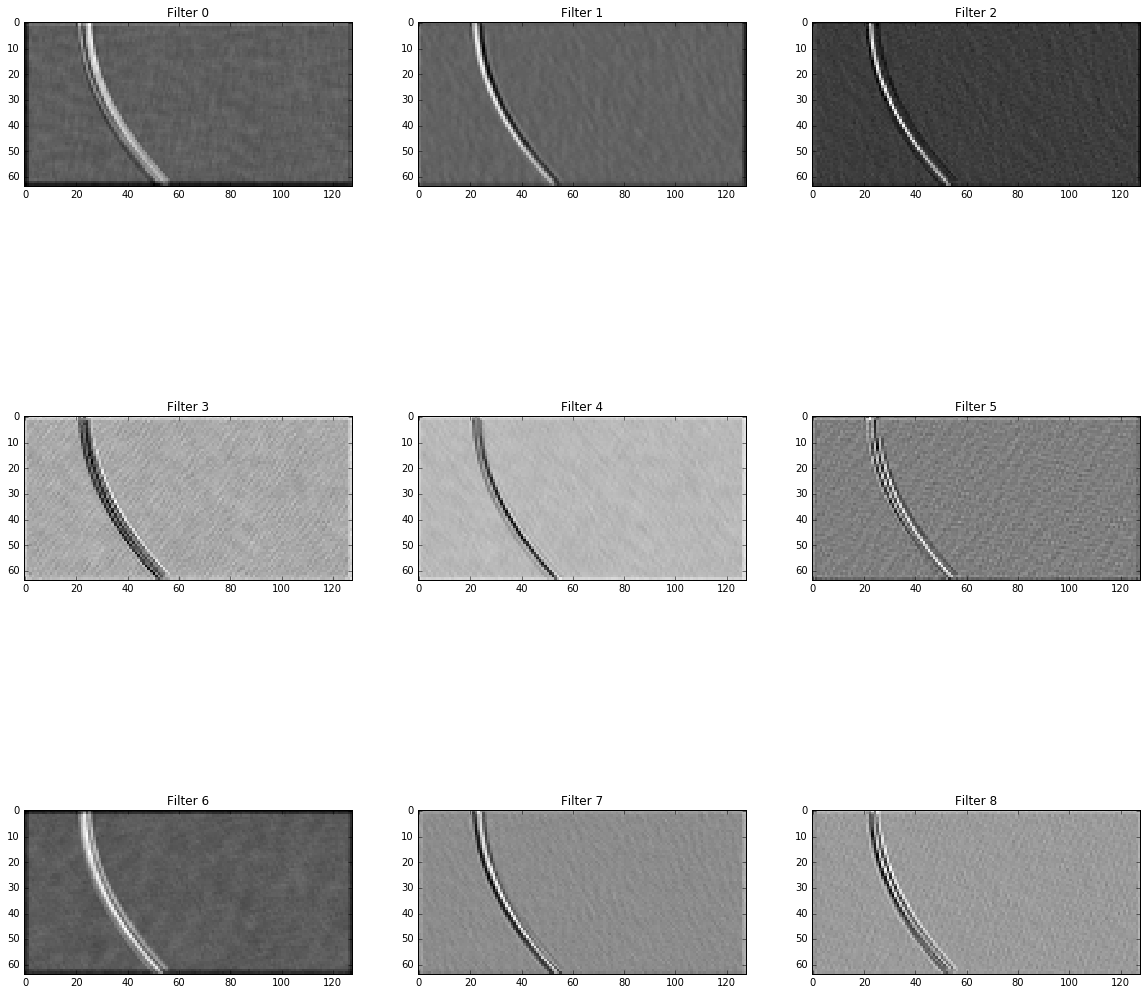

In [31]:
# Launch the graph
with tf.Session() as sess:
    sess.run(init)
    saver = tf.train.Saver(tf.all_variables())
    
    # load previously trained model if appilcable
    ckpt = tf.train.get_checkpoint_state(chk_directory)
    if ckpt:
        print "loading model: ",ckpt.model_checkpoint_path
        saver.restore(sess, ckpt.model_checkpoint_path)
    ActivatedUnits1 = sess.run(convolve1,feed_dict={x:np.reshape(sampleimage1,[1,64*128],order='F'),keep_prob:1.0})
    plt.figure(1, figsize=(20,20))
    n_columns = 3
    n_rows = 3
    for i in range(9):
        plt.subplot(n_rows, n_columns, i+1)
        plt.title('Filter ' + str(i))
        plt.imshow(ActivatedUnits1[0,:,:,i], interpolation="nearest", cmap="gray")

### Authors

<div class="teacher-image" style="    float: left;
    width: 115px;
    height: 115px;
    margin-right: 10px;
    margin-bottom: 10px;
    border: 1px solid #CCC;
    padding: 3px;
    border-radius: 3px;
    text-align: center;"><img class="alignnone wp-image-2258 " src="https://ibm.box.com/shared/static/tyd41rlrnmfrrk78jx521eb73fljwvv0.jpg" alt="Saeed Aghabozorgi" width="178" height="178" /></div>
#### Saeed Aghabozorgi

[Saeed Aghabozorgi](https://ca.linkedin.com/in/saeedaghabozorgi), PhD is Sr. Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

